
# SMART GRID OPTIMIZATION USING GENETIC ALGORITHM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import multiprocessing
from functools import partial
import time

## DATA GENERATION

In [ ]:
np.random.seed(42)
num_nodes = 10
num_sources = 3
hours = 24

In [ ]:
# Generate random demand (units)
demand_data = np.random.randint(50, 151, size=(num_nodes, hours))
demand_df = pd.DataFrame(demand_data, columns=[f'Hour_{h}' for h in range(hours)])
demand_df['Node'] = [f'Node_{i}' for i in range(num_nodes)]
demand_df.set_index('Node', inplace=True)

# Generate random supply (units)
supply_data = np.random.randint(200, 501, size=(num_sources, hours))
supply_df = pd.DataFrame(supply_data, columns=[f'Hour_{h}' for h in range(hours)])
supply_df['Source'] = [f'Source_{i}' for i in range(num_sources)]
supply_df.set_index('Source', inplace=True)

# Generate transmission loss matrix (2%–10%)
transmission_loss = np.random.uniform(0.02, 0.10, size=(num_sources, num_nodes))
transmission_df = pd.DataFrame(transmission_loss,
                                columns=[f'Node_{i}' for i in range(num_nodes)],
                                index=[f'Source_{i}' for i in range(num_sources)])

# EDA

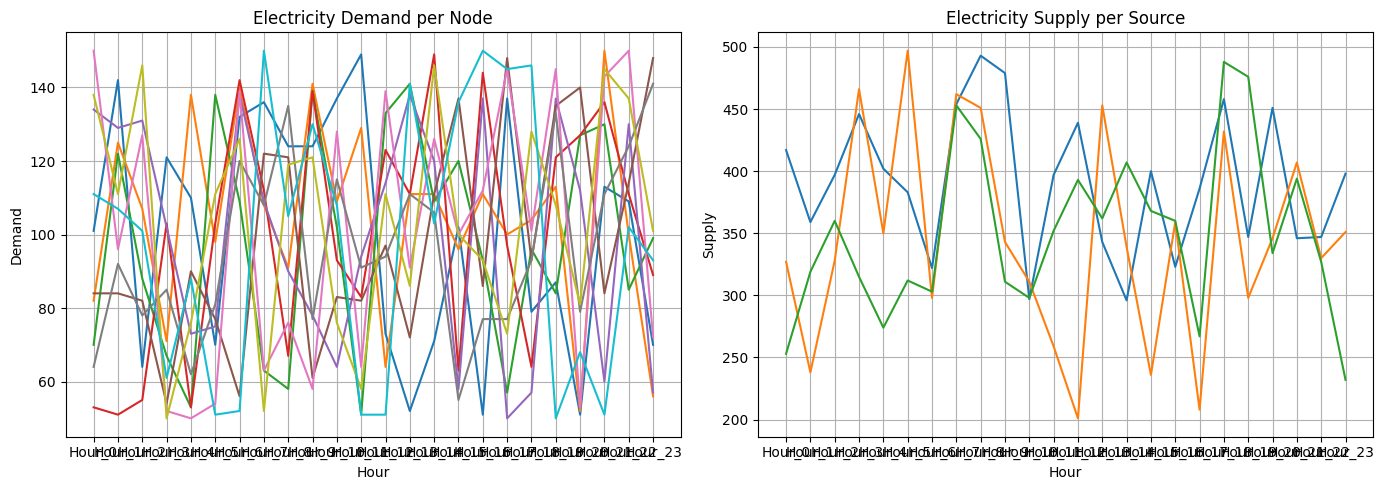

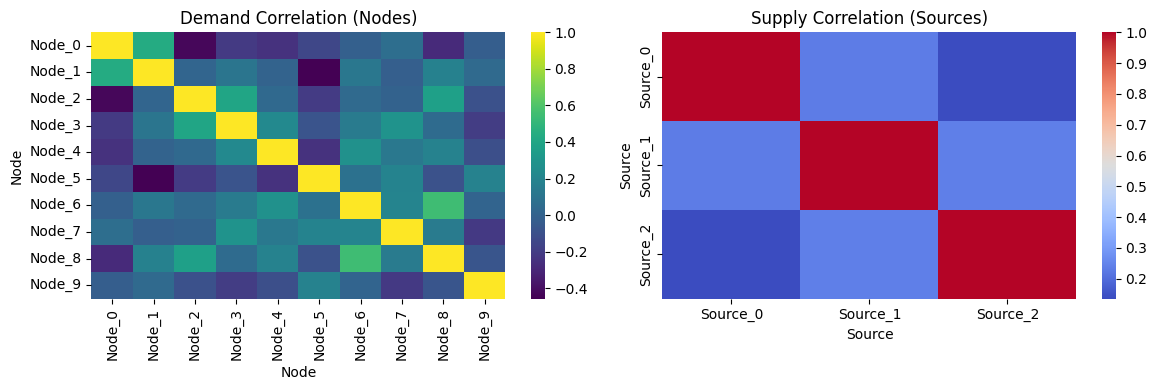

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(demand_df.T)
plt.title('Electricity Demand per Node')
plt.xlabel('Hour')
plt.ylabel('Demand')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(supply_df.T)
plt.title('Electricity Supply per Source')
plt.xlabel('Hour')
plt.ylabel('Supply')
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmaps
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(demand_df.T.corr(), cmap='viridis')
plt.title("Demand Correlation (Nodes)")

plt.subplot(1, 2, 2)
sns.heatmap(supply_df.T.corr(), cmap='coolwarm')
plt.title("Supply Correlation (Sources)")
plt.tight_layout()
plt.show()


# PREPROCESSING

In [ ]:
# Normalize data
normalized_demand = (demand_df - demand_df.min(axis=1).values.reshape(-1, 1)) / \
                    (demand_df.max(axis=1).values.reshape(-1, 1) - demand_df.min(axis=1).values.reshape(-1, 1))

normalized_supply = (supply_df - supply_df.min(axis=1).values.reshape(-1, 1)) / \
                    (supply_df.max(axis=1).values.reshape(-1, 1) - supply_df.min(axis=1).values.reshape(-1, 1))

# GENETIC ALGORITHM SETUP

In [ ]:
POPULATION_SIZE = 30
GENERATIONS = 50
MUTATION_RATE = 0.1

def generate_chromosome():
    chromosome = np.zeros((num_sources, num_nodes, hours))
    for h in range(hours):
        for n in range(num_nodes):
            total_demand = demand_df.iloc[n, h]
            allocations = np.random.dirichlet(np.ones(num_sources)) * total_demand
            for s in range(num_sources):
                chromosome[s, n, h] = allocations[s]
    return chromosome

def compute_fitness(chromosome, demand_df, supply_df, transmission_df):
    penalty = 0
    total_loss = 0
    total_cost = 0
    for h in range(hours):
        demand_fulfilled = np.sum(chromosome[:, :, h], axis=0)
        supply_used = np.sum(chromosome[:, :, h], axis=1)
        demand_required = demand_df.iloc[:, h].values
        supply_available = supply_df.iloc[:, h].values
        penalty += np.sum(np.abs(demand_required - demand_fulfilled))
        penalty += np.sum(np.maximum(0, supply_used - supply_available))
        loss = np.sum(chromosome[:, :, h] * transmission_df.values)
        total_loss += loss
        total_cost += np.sum(chromosome[:, :, h])
    fitness = - (penalty * 10 + total_loss * 100 + total_cost)
    return fitness

def tournament_selection(population, fitnesses, k=3):
    selected = random.sample(list(zip(population, fitnesses)), k)
    return max(selected, key=lambda x: x[1])[0]

def crossover(parent1, parent2):
    point = random.randint(1, hours - 1)
    child = np.copy(parent1)
    child[:, :, point:] = parent2[:, :, point:]
    return child

def mutate(chromosome):
    for _ in range(random.randint(1, 3)):
        s = random.randint(0, num_sources - 1)
        n = random.randint(0, num_nodes - 1)
        h = random.randint(0, hours - 1)
        chromosome[s, n, h] = random.uniform(0, 150)
    return chromosome

# GA EXECUTION (SERIAL)

In [ ]:
def run_ga_serial():
    population = [generate_chromosome() for _ in range(POPULATION_SIZE)]
    best_fitnesses = []
    for generation in range(GENERATIONS):
        fitnesses = [compute_fitness(ind, demand_df, supply_df, transmission_df) for ind in population]
        best_fitnesses.append(max(fitnesses))
        new_population = []
        for _ in range(POPULATION_SIZE):
            p1 = tournament_selection(population, fitnesses)
            p2 = tournament_selection(population, fitnesses)
            child = crossover(p1, p2)
            if random.random() < MUTATION_RATE:
                child = mutate(child)
            new_population.append(child)
        population = new_population
    return best_fitnesses


# GA EXECUTION (PARALLEL)


In [ ]:
def run_ga_parallel():
    population = [generate_chromosome() for _ in range(POPULATION_SIZE)]
    best_fitnesses = []
    for generation in range(GENERATIONS):
        with multiprocessing.Pool() as pool:
            fitnesses = pool.map(partial(compute_fitness,
                                         demand_df=demand_df,
                                         supply_df=supply_df,
                                         transmission_df=transmission_df), population)
        best_fitnesses.append(max(fitnesses))
        new_population = []
        for _ in range(POPULATION_SIZE):
            p1 = tournament_selection(population, fitnesses)
            p2 = tournament_selection(population, fitnesses)
            child = crossover(p1, p2)
            if random.random() < MUTATION_RATE:
                child = mutate(child)
            new_population.append(child)
        population = new_population
    return best_fitnesses

# RUN BOTH VERSIONS & COMPARE


In [ ]:

print("Running Serial GA...")
start_serial = time.time()
serial_result = run_ga_serial()
end_serial = time.time()
serial_time = end_serial - start_serial

print("Running Parallel GA...")
start_parallel = time.time()
parallel_result = run_ga_parallel()
end_parallel = time.time()
parallel_time = end_parallel - start_parallel

Running Serial GA...
Running Parallel GA...



# VISUALIZATION


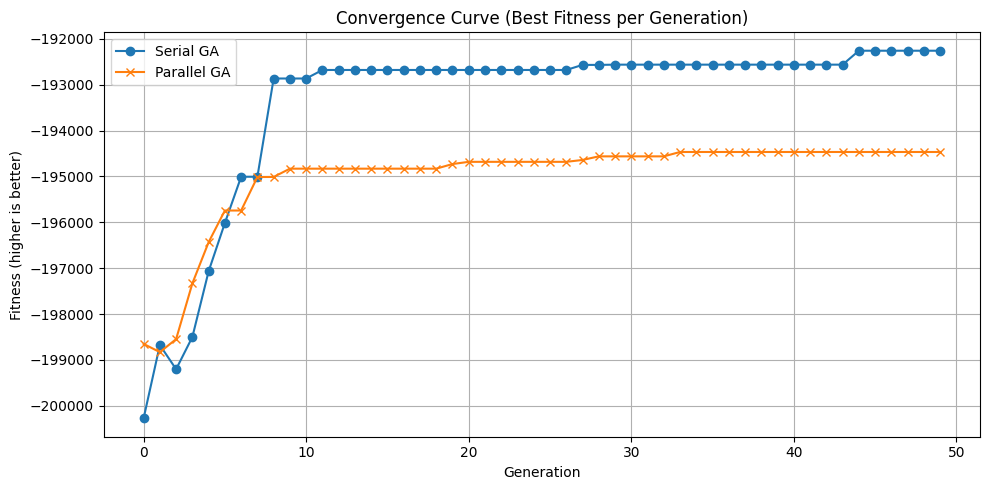

Serial GA Time: 11.96 seconds
Parallel GA Time: 9.01 seconds


In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(serial_result, label="Serial GA", marker='o')
plt.plot(parallel_result, label="Parallel GA", marker='x')
plt.title("Convergence Curve (Best Fitness per Generation)")
plt.xlabel("Generation")
plt.ylabel("Fitness (higher is better)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Serial GA Time: {serial_time:.2f} seconds")
print(f"Parallel GA Time: {parallel_time:.2f} seconds")

# 9. EVALUATION & PERFORMANCE ANALYSIS


Final Fitness Scores:
Best Serial Fitness: -192258.83
Best Parallel Fitness: -194466.95
Baseline (Greedy) Fitness: 0.00
Running with mutation rate: 0.01
Running with mutation rate: 0.05
Running with mutation rate: 0.1
Running with mutation rate: 0.2


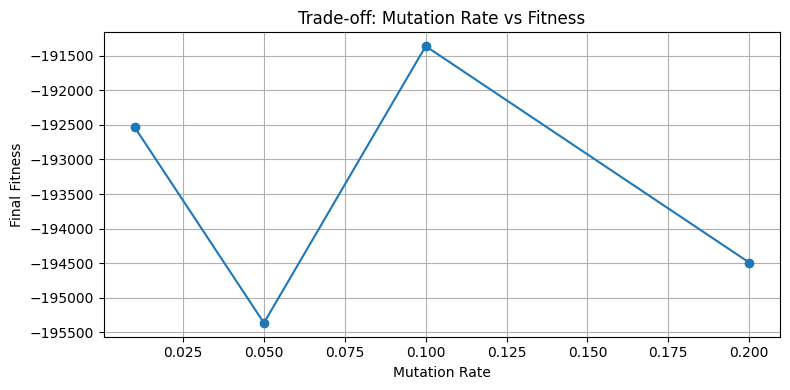


 Execution Time Summary:
Serial GA Time:   11.96 sec
Parallel GA Time: 9.01 sec


In [ ]:

# Final fitness values
best_serial_fitness = max(serial_result)
best_parallel_fitness = max(parallel_result)

print("Final Fitness Scores:")
print(f"Best Serial Fitness: {best_serial_fitness:.2f}")
print(f"Best Parallel Fitness: {best_parallel_fitness:.2f}")

# Baseline comparison using Greedy Method
def greedy_baseline(demand_df, supply_df):
    total_penalty = 0
    for h in range(hours):
        for n in range(num_nodes):
            demand = demand_df.iloc[n, h]
            supply_left = supply_df.iloc[:, h].copy()
            allocated = 0
            for s in supply_left.index:
                if supply_left[s] >= demand:
                    allocated = demand
                    supply_left[s] -= demand
                    break
            if allocated < demand:
                total_penalty += (demand - allocated)
    return -total_penalty * 10  # simulate similar scale as GA fitness

baseline_fitness = greedy_baseline(demand_df, supply_df)
print(f"Baseline (Greedy) Fitness: {baseline_fitness:.2f}")

# Trade-off Analysis: Parameter effect (e.g., mutation rate)
def run_ga_with_mutation_rate(rate):
    global MUTATION_RATE
    MUTATION_RATE = rate
    return run_ga_serial()

mutation_tests = [0.01, 0.05, 0.1, 0.2]
mutation_results = []

for r in mutation_tests:
    print(f"Running with mutation rate: {r}")
    scores = run_ga_with_mutation_rate(r)
    mutation_results.append((r, max(scores)))

# Plot mutation trade-off
rates = [r[0] for r in mutation_results]
scores = [r[1] for r in mutation_results]

plt.figure(figsize=(8, 4))
plt.plot(rates, scores, marker='o')
plt.title("Trade-off: Mutation Rate vs Fitness")
plt.xlabel("Mutation Rate")
plt.ylabel("Final Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

# Resource Usage Summary
print("\n Execution Time Summary:")
print(f"Serial GA Time:   {serial_time:.2f} sec")
print(f"Parallel GA Time: {parallel_time:.2f} sec")


In [ ]:
print("Total Demand:", demand_df.sum().sum())
print("Total Supply:", supply_df.sum().sum())

Total Demand: 23970
Total Supply: 26054


In [ ]:
demand_df.iloc[0, 0] = 1000000  # Unrealistically high demand to force a penalty
baseline_fitness = greedy_baseline(demand_df, supply_df)
print(f"Baseline (Greedy) Fitness: {baseline_fitness:.2f}")

Baseline (Greedy) Fitness: -10000000.00
